# Import Libraries

In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

# Load Data

In [2]:
TRAIN_DIR = ('../input/chest-xray-pneumonia/chest_xray/train/')
TEST_DIR = ('../input/chest-xray-pneumonia/chest_xray/test/')
VAL_DIR = ('../input/chest-xray-pneumonia/chest_xray/val/')

In [3]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

**Train Data**

In [4]:
IMG_SIZE= (150, 150)

In [5]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 2/2 [02:36<00:00, 78.37s/it]


5216 images loaded from ../input/chest-xray-pneumonia/chest_xray/train/ directory.


**Test Data**

In [6]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 2/2 [00:18<00:00,  9.46s/it]

624 images loaded from ../input/chest-xray-pneumonia/chest_xray/test/ directory.


**Validation Data**

In [7]:
X_val, y_val, val_labels = load_data(VAL_DIR,IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

16 images loaded from ../input/chest-xray-pneumonia/chest_xray/val/ directory.


In [8]:
def plot_samples(X, y, labels_dict, n=50):
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

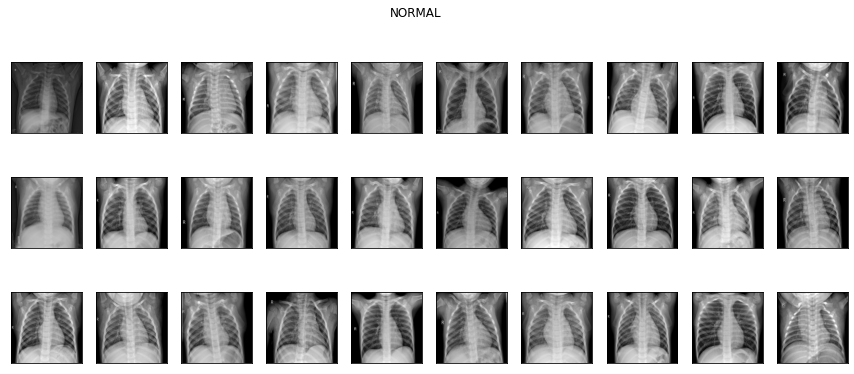

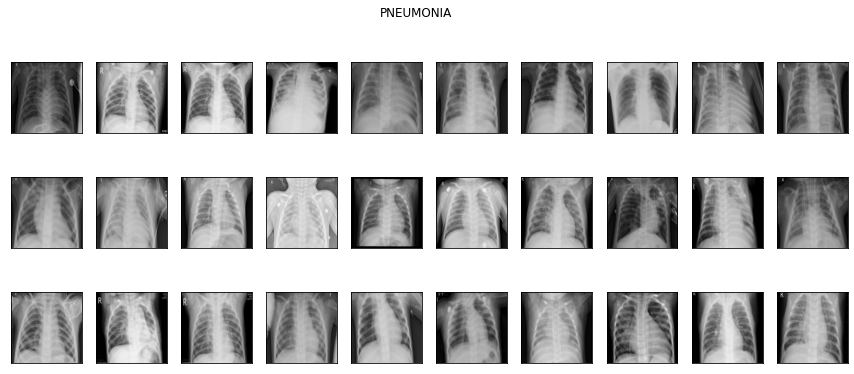

In [9]:
plot_samples(X_train, y_train, train_labels, 30)

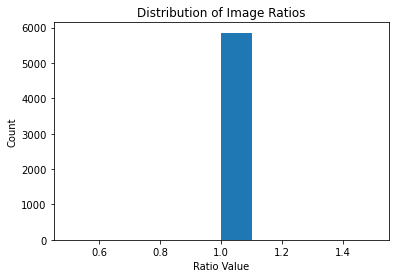

In [10]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

# Data Augmentation For Handling Overfitting

In [11]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
      directory=TRAIN_DIR, 
      target_size=(IMG_SIZE), 
      batch_size=batch_size, 
      class_mode='binary', 
      shuffle=True)

    val_gen = test_val_datagen.flow_from_directory(
      directory=VAL_DIR, 
      target_size=(IMG_SIZE), 
      batch_size=batch_size, 
      class_mode='binary', 
      shuffle=True)
    
    return train_gen, val_gen

In [12]:
train_gen, val_gen = process_data(IMG_SIZE, 32)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Build The Model

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(
        weights=None,
        include_top=False, 
        input_shape=IMG_SIZE + (3,)
    )

# base_model.summary()

In [14]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES,activation="sigmoid"))

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              33558528  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              4

In [15]:
epochs = 20
batch_size = 30

In [16]:
history = model.fit_generator(
    generator = train_gen,
    steps_per_epoch=50,
    epochs=epochs,
    validation_data = val_gen,
    validation_steps=25,
    
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20
50/50 [==============================] - 30s 493ms/step - loss: 0.8264 - accuracy: 0.7359 - val_loss: 0.7524 - val_accuracy: 0.5000
Epoch 2/20
50/50 [==============================] - 24s 476ms/step - loss: 0.6119 - accuracy: 0.7257
Epoch 3/20
50/50 [==============================] - 24s 473ms/step - loss: 0.5758 - accuracy: 0.7443
Epoch 4/20
50/50 [==============================] - 23s 465ms/step - loss: 0.5816 - accuracy: 0.7321
Epoch 5/20
50/50 [==============================] - 23s 465ms/step - loss: 0.4488 - accuracy: 0.7696
Epoch 6/20
50/50 [==============================] - 24s 478ms/step - loss: 0.4076 - accuracy: 0.8292
Epoch 7/20
50/50 [==============================] - 23s 461ms/step - loss: 0.3186 - accuracy: 0.8721
Epoch 8/20
50/50 [==============================] - 23s 463ms/step - loss: 0.3555 - accuracy: 0.8363
Epoch 9/20
50/50 [==============================] - 24s 486ms/step - loss: 0.2953 - accuracy: 0.8811
Epoch 10/20
50/50 [==============================

In [17]:
# def deep_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
   
#     model.compile(optimizer=RMSprop(lr=1e-4)
#                   , loss='categorical_crossentropy'
#                   , metrics=['accuracy'])
    
#     history = model.fit(X_train
#                        , y_train
#                        , epochs=epochs
#                        , batch_size=batch_size
#                        , validation_data=(X_val, y_val)
#                        , verbose=1)
#     return history

In [18]:
# history = deep_model(model, X_train, y_train, X_val, y_val, epochs, batch_size)

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

train Accuracy = 0.93


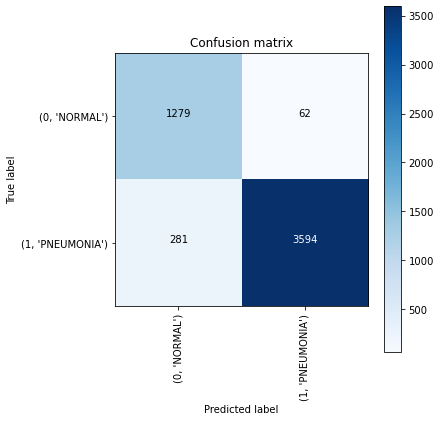

In [20]:
# validate on train set

predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('train Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_train, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

Test Accuracy = 0.92


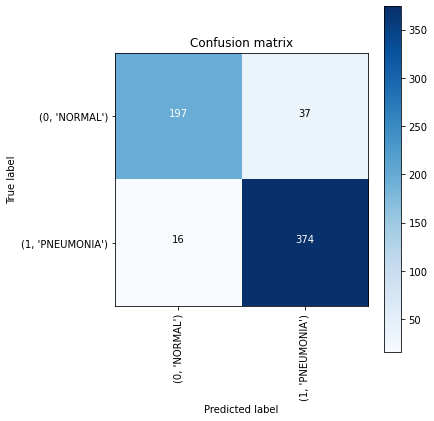

In [21]:
# validate on test set

predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

In [22]:
# def eval_metric(model, history, metric_name):
    
#     metric = history.history[metric_name]
#     val_metric = history.history['val_' + metric_name]
#     e = range(1, len(metric) + 1)
#     plt.plot(e, metric, 'bo', label='Train ' + metric_name)
#     plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
#     plt.xlabel('Epoch number')
#     plt.ylabel(metric_name)
#     plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
#     plt.legend()
#     plt.show()